# Figure 3: Region choices for power-law background

In [1]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial
import gzip
from pathlib import Path
import pickle

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

from common import draw_limits, sketch_dist, log_x
import hypney.all as hp

plt.rcParams["text.usetex"] =  True

In [2]:
def powerlaw(similarity, mu):
    if similarity == 0:
        return hp.DiracDelta(rate=mu, loc=1)
    return hp.powerlaw(a=1/similarity, rate=mu)

mu_signal = hp.DEFAULT_RATE_GRID
mu_signal_clip = mu_signal[mu_signal < 100][1:]  # For Yellin Hawk
signal = hp.uniform().fix_except('rate')
background = powerlaw

In [3]:
n_toys = 10_000
ibm = dict(
    blue='#648FFF',
    purple='#785EF0',
    red='#DC267F',
    orange='#FE6100',
    gold='#FFB000',
)

fixed_hawk = hp.FixedRegionSimpleHawk
allregion_hawk = hp.AllRegionSimpleHawk
stat_prefix = 'lr'

methods = dict(
    full_space=dict(
        statistic=fixed_hawk(signal, cuts=((0, 1),), signal_only=True), 
        dist_name=f'{stat_prefix}_full',
        style=dict(color="k", linestyle="-"), 
        label="Full space only"
    ),

    
    left_regions=dict(
        statistic=allregion_hawk(signal, signal_only=True, regions_type='left'),
        dist_name=f'{stat_prefix}_oneside',
        style=dict(color=ibm['gold']),
        #label='$H[t_0, (0,\ldots)]$'
        label='Left fixed at $0$'
        #r"$[0,\ldots]$ intervals"
    ),

#     gaps=dict(
#         statistic=allregion_hawk(signal, signal_only=True, n_max=0),
#         dist_name=f'{stat_prefix}_gaps', 
#         style=dict(color="steelblue"),
#         label="$I_0$ (gaps)"
#     ),


    s4=dict(
        statistic=fixed_hawk(signal, cuts=hp.uniform_sn_cuts(4), signal_only=True), 
        dist_name=f'{stat_prefix}_s4',
        style=dict(
            color=ibm['purple'],
            #color=colors[0],
            linestyle='--'
            #color="darkorange"
        ), 
        #label='$H[t_0, S_4]$',
        label="$S_4$ (ends at quartiles)"
    ),
    
    left_right_regions=dict(
        statistic=allregion_hawk(signal, signal_only=True, regions_type=('left', 'right')),
        dist_name=f'{stat_prefix}_left_right',
        style=dict(color=ibm['orange'],
                   #linestyle='--'
                   #linestyle=":"
                  ),
        #label='$H[t_0, (\ldots, 1) \cup (0, \ldots)]$'
        label='One end at 0/1'
    ),

    all_regions=dict(
        statistic=allregion_hawk(signal, signal_only=True),
        dist_name=f'{stat_prefix}_all',
        style=dict(color=ibm['blue'], linewidth=1.5),
        #label=r'$H[t_0, \mathrm{all} \; \mathrm{intervals}]$'#"H{All intervals"
        label='All intervals'
    ),
    
    

#     s5=dict(
#         statistic=fixed_hawk(signal, cuts=hp.uniform_sn_cuts(5), signal_only=True), 
#         dist_name=f'{stat_prefix}_s5',
#         style=dict(color="darkorange", linestyle=':'), 
#         label="$S_5$"),

    right_regions=dict(
        statistic=allregion_hawk(signal, signal_only=True, regions_type='right'),
        dist_name=f'{stat_prefix}_oneside',
        style=dict(color=ibm['red'],
                   #linestyle='--'
                   #linestyle='--', alpha=0.5
                  ),
        #label='$H[t_0, (\ldots, 1)]$'
        label=r"Right fixed at 1"
    ),
    
    s10=dict(
        statistic=fixed_hawk(signal, cuts=hp.uniform_sn_cuts(10), signal_only=True), 
        dist_name=f'{stat_prefix}_s10',
        style=dict(
            #color="coral"
            color=ibm['purple'],
            #color=colors[0],
            linestyle='dashdot'
        ),
        #label='$H[t_0, S_{10}]$',
        label='$S_{10}$ ($\ldots$ deciles)'
    ),

#     central_regions_sym=dict(
#         statistic=allregion_hawk(signal, signal_only=True, 
#                                  regions_type='central_symmetric', central_point=0.5),
#         dist_name=f'{stat_prefix}_central_sym',
#         style=dict(color="crimson"),
#         label="Central symmetric",
#     ),

#     central_regions_asym=dict(
#         statistic=allregion_hawk(signal, signal_only=True,
#                                  regions_type='central', central_point=0.5),
#         dist_name=f'{stat_prefix}_central_asym',
#         style=dict(color="crimson", linestyle="--"),
#         label="Central asymmetric",
#     ),
    
#     opt_itv=dict(
#         statistic=hp.YellinCNHawk(signal).with_stored_dist('yellin_cn_149max', rate_anchors=mu_signal_clip),
#         style=dict(color='magenta'),
#         label='Yellin opt.itv.'
#     )
)

# Build/load distributions (should be OK here, see region_choice)
for method_name, r in methods.items():
    if 'dist_name' in r:
        r['statistic'] = r['statistic'].with_stored_dist(r['dist_name'], n_toys=n_toys)
        
with gzip.open('poisson_sens.pkl.gz', mode='rb') as f:
    poisson_sens = pickle.load(f)
poisson_kind = 'augmented'
poisson_sens = poisson_sens[poisson_kind]

## Performance contour plot

In [4]:
%%time
# 2k trials with 1+25 mu_bgs took ~6 hours
# With 1 + 15 mu_bgs:
# 20 trials: 6min 54s = 484 sec. Not parallel though...
# 50 trials: 301sec. (parallel on)
# 500 trials: Wall time: 42min 3s

# Avoid 0, but make sure to hit 0.5 and 1
similarities = np.concatenate([
    np.linspace(1e-3, 0.5, 7), 
    np.linspace(0.5, 1, 7)[1:]])
mu_bgs = np.concatenate([
    np.array([0.2, 1]),
    np.geomspace(2, 1000, 1 + 25)
])

n_toy_limits = 2000
parallel = True
tolerant = True
cache_folder = Path('./limits_regions_plaw/')
cache_folder.mkdir(exist_ok=True)

def draw_all_limits(similarity, *, s):
    results = np.zeros((len(mu_bgs), n_toy_limits))
    for mu_i, mu_bg in enumerate(mu_bgs):

        bg_only = background(similarity, mu_bg).freeze()
        stat = s['statistic']

        # Get toy limits
        anchors = (mu_signal_clip if isinstance(stat, hp.YellinCNHawk) else mu_signal)
        ul = hp.UpperLimit(stat, anchors=list(anchors))
        results[mu_i] = draw_limits(ul, bg_only, n_toy_limits, tolerant=tolerant)
    return results
    

for stat_name, s in methods.items():
    limits_fn = cache_folder / f'{stat_name}_{len(similarities)}_{len(mu_bgs)}_{n_toy_limits}.pkl.gz'
    if limits_fn.exists():
        with gzip.open(limits_fn, mode='rb') as f:
            s['limits'] = pickle.load(f)
    else:
        print(f"Running toy mcs for {stat_name}")
        s['limits'] = np.zeros((len(similarities), len(mu_bgs), n_toy_limits))
    
        if parallel:
            with ProcessPoolExecutor(max_workers=min(7, len(similarities))) as exc:
                s['limits'] = np.stack(list(exc.map(
                partial(draw_all_limits, s=s), 
                similarities)))
        else:
            s['limits'] = np.asarray([
                draw_all_limits(similarity=similarity, s=s)
                for similarity in similarities])

        with gzip.open(limits_fn, mode='wb') as f:
            pickle.dump(s['limits'], f)

CPU times: user 160 ms, sys: 8.06 ms, total: 168 ms
Wall time: 169 ms


In [5]:
assert similarities[similarities.size//2] == 0.5

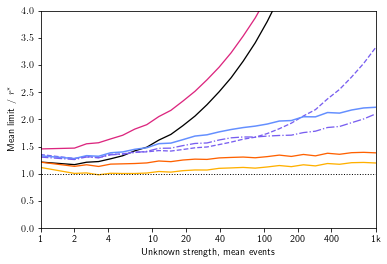

In [6]:
def plot_1d(sim_i=similarities.size//2):
    show_rel = False
    show_bars = False
    similarity = similarities[sim_i]

    max_n = 1200
    min_valid = 0.8

    for method_name, r in methods.items():
        x = r['limits'][sim_i]
        valid_f = np.mean(x < max_n, axis=1)
        r['mean'] = np.where(
            valid_f > min_valid,
            x.clip(None, max_n).mean(axis=1),
            float('nan')
        )
        r['err'] = np.where(
            valid_f > min_valid,
            x.clip(None, max_n).std(axis=1) / x.shape[1]**0.5,
            0
        )
        
    with gzip.open(f'clairvoyant_sens_{poisson_kind}.pkl.gz', mode='rb') as f:
        clairvoyant_sens = pickle.load(f)
        cv_y = np.interp(
            mu_bgs,
            clairvoyant_sens['mu_unknown'],
            clairvoyant_sens['triangle'])

    scale = interpolate.interp1d(
        clairvoyant_sens['mu_unknown'],
        clairvoyant_sens['triangle'])(mu_bgs)
    ax = plt.gca()
    
    for method_name, r in methods.items():
        mean, err = r['mean'], r['err']
        opts = dict(
            **{**dict(linewidth=1.3), **r['style']},
            label=r['label'])
        if show_bars:
            ax.errorbar(mu_bgs, mean / scale, yerr=err / scale, 
                        #marker='.',
                        **opts)
        else:
            ax.plot(mu_bgs, mean / scale, **opts)

    ax.plot(mu_bgs, 
            cv_y / scale,
            c='k', 
            #label='Best single region', 
            linewidth=1,
            linestyle=':')

    log_x(1, 1000 + 1e-9, tick_at=[1, 2, 4])
    xticks = plt.xticks()[0]
    plt.xticks(xticks, ['%g' % x for x in xticks[:-1].tolist()] + ['1k'])

    #log_y(2, 1000)
    #log_y(0.8, 5)
    plt.ylabel("Mean limit / $r^*$")
    plt.ylim(0, 4)

    # legend = plt.legend(bbox_to_anchor=(1,1.05),
    #                     loc='upper left', frameon=False)
    plt.xlabel("Unknown strength, mean events")

    # add_axes([xmin,ymin,dx,dy])
#     plt.sca(fig.add_axes([0.2, 0.72 if show_rel else 0.64, 
#                           0.13, .7/height]))
#     sketch_dist(powerlaw(similarity, 1), xlabel='Unknown shape\n(vs. flat signal)')

    # plt.savefig(
    #     f'{study_name}_{stat_prefix}_{n_trials}_{rate_unknown.size}.png',
    #     dpi=200, bbox_inches='tight', bbox_extra_artists=[legend])
    
fig = plt.figure()
plot_1d()

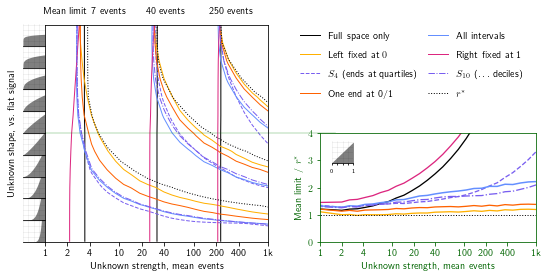

In [7]:
levels = 7, 40, 250
lw = 1

with gzip.open(f'clairvoyant_sens_{poisson_kind}.pkl.gz', mode='rb') as f:
    clairvoyant_sens = pickle.load(f)

fig = plt.figure(figsize=(4,4))

for statname, s in methods.items():
    s['sensitivity'] = y = np.mean(s['limits'], axis=2)
    color = s.get('style', dict()).get('color', 'gray')
    linestyle = s.get('style', dict()).get('linestyle', '-')

    #for level, linestyle in zip(levels, linestyles):
    for level in levels:
        plt.contour(mu_bgs, similarities, y,
                    levels=[level],
                    linewidths=lw,
                    linestyles=linestyle,
                    colors=color)
    # Null line plot, so legend has something
    plt.plot([0], [0], 
             label=s.get('label', statname), 
             linestyle=linestyle,
             color=color, 
             linewidth=lw)

# TODO: update clairvoyant sens
mu_bgs_old = np.concatenate([
    np.array([0.2, 1]),
    np.geomspace(2, 1000, 1 + 15)
])
plt.contour(
    mu_bgs_old, 
    similarities,
    clairvoyant_sens['plaw'].T, 
    levels=levels, 
    linewidths=lw,
    linestyles=':',
    colors='k',
)
plt.plot([], [], linestyle=':', linewidth=lw, c='k', label='$r^*$')
    
legend = plt.legend(
    loc='upper left',
    bbox_to_anchor=(1.1, 1.01),
    #bbox_to_anchor=(-0.15, -0.2),
    ncol=2,
    columnspacing=1,
    labelspacing=1,
    frameon=False,)

plt.ylabel("Unknown shape, vs. flat signal", labelpad=29)
plt.ylim(0, 1)
plt.yticks([])

plt.xlabel("Unknown strength, mean events")
log_x(1, 1000 + 1e-9, tick_at=[1, 2, 4])
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
xticks = plt.xticks()[0]
plt.xticks(xticks, ['%g' % x for x in xticks[:-1].tolist()] + ['1k'])

# Mean limit contour labels
ypos = 1.05
for i, l in enumerate(levels):
    xpos = np.exp(np.interp(np.log(l), 
                            np.log(methods['full_space']['sensitivity'][-1]), 
                            np.log(mu_bgs)))
#     plt.text(xpos, ypos, f'\mbox{{}}\hspace{{0.5cm}}$\;\;{l}$ events' if i == 0 else f'{l}',
#              ha='left' if i == 0 else 'center')
    if i == 0:
        plt.text(xpos, ypos, f'Mean limit {l} events', ha='center')
    else:
        plt.text(xpos * 0.7, ypos, f'{l} events', ha='left')

# plt.annotate(
#     '', 
#     axis_to_data(0.95, 0.95), 
#     xytext=axis_to_data(.87, .87),
#     arrowprops=dict(arrowstyle='->'))
# plt.text(
#     *axis_to_data(0.885, .845), "Better", 
#     rotation=45, fontsize=6)
        
plt.axhline(0.5, c='g', alpha=0.2, xmax=1.3, clip_on=False)
    
# Distribution sketches
n_sketch = 10
width = 0.1
xpos = 0.04825
sketch_sims = np.linspace(0, 1, n_sketch + 2)[1:-1]
y_start = 0.125  # y matching lower spine
y_end = 0.882    # y matching upper spine
width = (y_end - y_start) / n_sketch
for i, sim in enumerate(sketch_sims):
    plt.sca(fig.add_axes([xpos, y_start + i * width, 
                          width, width]))
    sketch_dist(powerlaw(sim, 1), xlabel=None)


ax = fig.add_axes([1.08, 0.1245, 0.75, 0.378])
plt.sca(ax)
c = 'darkgreen'
ax.tick_params(color=c, labelcolor=c)
for spine in ax.spines.values():
    spine.set_edgecolor(c)
ax.xaxis.label.set_color(c)
ax.yaxis.label.set_color(c)
plot_1d()

ax = fig.add_axes([1.12, 0.4, width, width])
sketch_dist(powerlaw(0.5, 1), xlabel='')
ax.tick_params(axis='x', which='both',length=2)
ax.xaxis.set_ticklabels(['0', '', '', '', '1'], fontsize=6)
    
for fmt in 'png', 'pdf':
    plt.savefig(f'regioncomp_plaw_{n_toy_limits}_{poisson_kind}.{fmt}',
                dpi=200, bbox_inches='tight')
plt.show()